<a id='start'></a>
# Transforming

During the data gathering phase, your goal was to record as much data about your observations as possible since you never know which features are going to end up being the golden ones that allow your machine learning algorithm to succeed. Due to this, there usually are a few redundant or even poor features in your dataset. <br>
*To be effective, many machine learning algorithms need their input data to be discerning, discriminating and independent.* <br>
In this notebook, we are going to discover methods to get your data behaving like that using transformers. This will help improve your own knowledge of your data, as well as improve your machine learning algorithm's performance.

This notebook will present the [Principal Component Analysis - PCA](#section1)<a href='#section1'></a>.


<a id='section1'></a>
## 1) Principal Component Analysis - PCA
PCA and other dimensionality reduction methods, have three main uses: <br>
1) Reducing the dimensionality and thus complexity of your dataset; <br>
2) Pre-process your data in preparation for other supervised learning tasks, such as regression and classification; <br>
3) To make visualizing your data esaier.


Principal Component Analysis (PCA), is a transformation that attempts to convert possibly correlated features into a set of linearly uncorrelated ones. <br>
In many real-world datasets, we aren't aware of what specifically needs to be measured to address the issue driving our data collection. <br>
So instead, we simply collect any feature we can measure, usually resulting in a higher dimensionality (*a lot of features of the dataset*) than what is truly needed. This is undesirable, but it's the only reliable way to ensure we capture the relationship modeled by our data. 
<br> 
<br>
If we have reason to believe the question we want solved can be answered using a subset of our collected features, or if the features we've collected are actually many indirect observations of some inherent property we either cannot or do not know how to directly measure, then dimensionality reduction might work for us. <br>
**PCA's approach to dimensionality reduction is to derive a set of degrees of freedom that can then be used to reproduce most of the variability of our data.** <br>
By PCA, first find the center of our data, based off its numeric features. Next, it would search for the direction that has the most variance or widest spread of values. That direction is the principal component vector, so it is added to a list. By searching for more directions of maximal variance that are orthogonal to all previously computed vectors, more principal component can then be added to the list. <br>
This set of vectors form a new feature space that can represent our samples with.<br>
PCA ensures that each newly computed view (feature) is orthogonal or linearly independent to all previously computed ones, minimizing these overlaps. PCA also orders the features by importance, assuming that the more variance expressed in a feature, the more important said feature is.<br>
With the newly computed features ordered by importance, dropping the least important features on the list intelligently reduces the number of dimensions needed to represent your dataset, with minimal loss of information. <br>
The remain group of features are the *principal components*, and they are the best possible, linearly independent combination of features that we can use to describe your data. <br>


Try to better understand PCA with an example:

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

from sklearn import preprocessing

plt.style.use('ggplot')

In [210]:
# Defining a function for scaling the features of a dataset

def scaleFeaturesDF(df):
    # Feature scaling is a type of transformation that only changes the
    # scale, but not number of features. Because of this, we can still
    # use the original dataset's column names... so long as we keep in
    # mind that the _units_ have been altered:
    
    scaled = preprocessing.StandardScaler(with_mean = False).fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    print("New Variances:\n", scaled.var())
    print("New Describe:\n", scaled.describe())
    
    return scaled

SKLearn contains many methods for transforming our features by scaling them, a type of [pre-processing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)):
- [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)
- [`Normalizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)
- [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
<br>

However in order to be effective at PCA, there are a few requirements that must be met, and which will drive the selection of your scaler. **PCA requires our data is standardized**, in other words, *it's mean should equal 0, and it should have unit variance*.

SKLearn's regular `Normalizer()` doesn't zero out the mean of your data, it only clamps it, so it could be inappropriate to use depending on your data. `MinMaxScaler` and `MaxAbsScaler` both fail to set a unit variance, so you won't be using them here either. `RobustScaler` can work, again depending on your data (watch for outliers!). So for this assignment, we're going to use the `StandardScaler`. 

In [211]:
# Defining a function for visualizations

def drawVectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes() # No cheating ;-)

    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax


In [212]:
scaleFeatures = True

Load up the dataset for doing a PCA analysis. <br>
We will use the dataset of [Chronic Kidney Disease](https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease)

In [213]:
kidn_dis = pd.read_csv('kidney_disease.csv')
kidn_dis.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [214]:
kidn_dis.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [215]:
# Investigating the main characteristic of the dataset

print("Shape of the dataset:", kidn_dis.shape)


Shape of the dataset: (400, 26)


In [216]:
kidn_dis.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [217]:
kidn_dis.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [218]:
kidn_dis.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


In [219]:
# Count na
kidn_dis.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [220]:
# Drop the id column
kidn_dis = kidn_dis.drop(['id'], axis = 1)

# Drop any na
kidn_dis = kidn_dis.dropna(axis=0)
kidn_dis.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd


**Pay attention to the index rows!** After a dropna some rows has been deleted, it could be better to [reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html) the dataframe:

In [221]:
kidn_dis.reset_index(inplace = True)
kidn_dis.head()

,index,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
1,9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,...,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
2,11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,...,32,4500,3.8,yes,yes,no,poor,yes,no,ckd
3,14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,...,16,11000,2.6,yes,yes,yes,poor,yes,no,ckd
4,20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,ckd


In [222]:
kidn_dis.isnull().sum()

index             0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

In [223]:
print("After dropping na, the rows of the dataset are:", kidn_dis.shape[0])

After dropping na, the rows of the dataset are: 158


The actual label feature will be removed prior to executing PCA, since it's unsupervised.<br> 
We're only labeling by color so we can see the effects of PCA:

In [224]:
# We define color red if the record is 'ckd' for the features classification, while green if it is 'notckd'
labels = ['red' if i=='ckd' else 'green' for i in kidn_dis.classification]

For semplicity of calculation, we will remove maintain only numeric columns

In [225]:
kidn_dis_2 = kidn_dis.loc[:, ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']]
kidn_dis_2.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
0,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2
1,53.0,90.0,1.020,2.0,0.0,70.0,107.0,7.2,114.0,3.7,9.5
2,63.0,70.0,1.010,3.0,0.0,380.0,60.0,2.7,131.0,4.2,10.8
3,68.0,80.0,1.010,3.0,2.0,157.0,90.0,4.1,130.0,6.4,5.6
4,61.0,80.0,1.015,2.0,0.0,173.0,148.0,3.9,135.0,5.2,7.7


In [226]:
kidn_dis_2.dtypes

age     float64
bp      float64
sg      float64
al      float64
su      float64
bgr     float64
bu      float64
sc      float64
sod     float64
pot     float64
hemo    float64
dtype: object

PCA Operates based on variance. The variable with the greatest variance will dominate.

In [227]:
kidn_dis_2.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,49.563291,74.050633,1.019873,0.797468,0.253165,131.341772,52.575949,2.188608,138.848101,4.636709,13.687342
std,15.512244,11.175381,0.005499,1.413130,0.813397,64.939832,47.395382,3.077615,7.489421,3.476351,2.882204
min,6.000000,50.000000,1.005000,0.000000,0.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000
25%,39.250000,60.000000,1.020000,0.000000,0.000000,97.000000,26.000000,0.700000,135.000000,3.700000,12.600000
50%,50.500000,80.000000,1.020000,0.000000,0.000000,115.500000,39.500000,1.100000,139.000000,4.500000,14.250000
75%,60.000000,80.000000,1.025000,1.000000,0.000000,131.750000,49.750000,1.600000,144.000000,4.900000,15.775000
max,83.000000,110.000000,1.025000,4.000000,5.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000


Each Standard deviation is a lot of different from each other; so it is necessary scaling the datas:

In [228]:
df = kidn_dis_2
if scaleFeatures: df = scaleFeaturesDF(df)

New Variances:
 age     1.006369
bp      1.006369
sg      1.006369
al      1.006369
su      1.006369
bgr     1.006369
bu      1.006369
sc      1.006369
sod     1.006369
pot     1.006369
hemo    1.006369
dtype: float64
New Describe:
               age          bp          sg          al          su         bgr  \
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000   
mean     3.205267    6.647298  186.056041    0.566122    0.312233    2.028946   
std      1.003180    1.003180    1.003180    1.003180    1.003180    1.003180   
min      0.388021    4.488347  183.342676    0.000000    0.000000    1.081348   
25%      2.538305    5.386016  186.079134    0.000000    0.000000    1.498440   
50%      3.265844    7.181355  186.079134    0.000000    0.000000    1.784225   
75%      3.880211    7.181355  186.991287    0.709899    0.000000    2.035252   
max      5.367625    9.874362  186.991287    2.839596    6.166608    7.569438   

               bu          sc        

To get started, **import PCA from sklearn.decomposition** and then create a new instance of the model setting the *n_components* parameter to the number of dimensions you wish to keep. This value has to be less than or equal to the number of features in our original dataset, since each computed component is a linear combination of our original features. <br>
The second parameter, *svd_solver*, dictates if a full singular value decomposition should be preformed on our data, or a randomized truncated one. If we decide to use randomized, be sure to seed the random_state variable whenever if we intend on producing replaceable results.

Once we've fit the model against our dataframe, we can use it to transform our dataset's observatios (or any other observation that share its feature space) into the newly computed, principal component feature space with the **.transform()** method. <br>
This transformation is bidirectional, so we can recover our original feature values using **.inverse_transform()** so long as we don't drop any components. If even one component was removed, then after performing the inverse transformation back to the regular feature space, there will be some signs of information loss proportional to which component was dropped.

Run [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on our dataset, reducing it to 2 principal components.

In [229]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(df)
PCA(copy=True, n_components=2, whiten=False)
T = pca.transform(df)

There are a few other interesting model attribute that SciKit-Learn exposes to us after we've trained our PCA model with the .fit() method: <br>
- **components_**: These are our principal component vectors and are linear combinations of our original features. As such, they exist within the feature space of our original dataset.
- **explained_variance_**: This is the calculated amount of variance which exists in the newly computed principal components.
- **explained_variance_ratio_**: Normalized version of *explained_variance_* for when our interest is with probabilities.

In [230]:
pca.explained_variance_ratio_

array([0.46887433, 0.11861083])

Features by importance:
 [(3.742707961689753, 'bgr'), (3.658217146100349, 'su'), (3.3010558177199676, 'sc'), (3.2135627781092313, 'bu'), (3.0289895717843365, 'hemo'), (3.005954104973676, 'al'), (2.7191175570104855, 'sg'), (2.6796247845309895, 'sod'), (2.1807533403156887, 'age'), (1.5558908768066326, 'bp'), (1.0207934019176799, 'pot')]


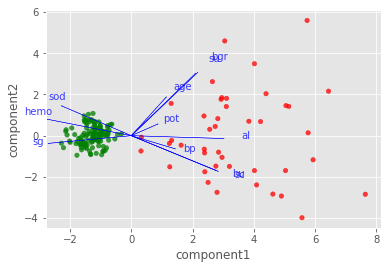

In [231]:
# Since we transformed via PCA, we no longer have column names; but we know we
# are in `principal-component` space, so we'll just define the coordinates accordingly:
ax = drawVectors(T, pca.components_, df.columns.values, plt, scaleFeatures)
T  = pd.DataFrame(T)

T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)

plt.show()

In [137]:
T.head()

,component1,component2
0,3.204188,-1.491743
1,2.799523,-2.747285
2,3.109582,1.810783
3,4.219809,0.684029
4,2.849842,-0.800630


After doing a PCA, we'll lost the header of the dataframe, so it could be difficult understand which features of the dataset could describe hypotetical linear relationship between the datas. <br>
To interpret each component, we must compute the correlations between the original data and each principal component. <br>
These correlations are obtained using the correlation procedure. In the variable statement we include the two principal components, "component1 and component2", in addition to all eleven of the original variables. 

We will note that if we look at the principal components themselves, then there is zero correlation between the components.

In [114]:
# Concating PCA's dataframe and starting dataset
df_corr = pd.concat([T, df], axis = 1)

In [115]:
df_corr.head()

,component1,component2,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
0,3.204188,-1.491743,-0.101098,-0.363613,-2.713365,2.273474,-0.312233,-0.221549,0.072474,0.525250,-3.730148,-0.616596,-0.865744
1,2.799523,-2.747285,0.222253,1.431726,0.023092,0.853676,-0.312233,-0.947597,1.151950,1.633514,-3.328309,-0.270309,-1.457446
2,3.109582,1.810783,0.868954,-0.363613,-1.801213,1.563575,-0.312233,3.841231,0.157139,0.166693,-1.051224,-0.126022,-1.004968
3,4.219809,0.684029,1.192305,0.534056,-1.801213,1.563575,2.154410,0.396364,0.792125,0.623038,-1.185170,0.508838,-2.814879
4,2.849842,-0.800630,0.739614,0.534056,-0.889060,0.853676,-0.312233,0.643529,2.019764,0.557846,-0.515439,0.162550,-2.083954


In [116]:
corr_matrix = df_corr.corr()
corr_matrix

,component1,component2,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
component1,1.000000e+00,4.415274e-17,0.337272,0.422522,-0.800703,0.892647,0.619927,0.642218,0.815133,0.837989,-0.672209,0.254235,-0.864567
component2,4.415274e-17,1.000000e+00,0.380518,-0.129321,-0.076072,-0.028140,0.614101,0.624447,-0.342387,-0.350963,0.293755,0.113870,0.172929
age,3.372723e-01,3.805183e-01,1.000000,0.079712,-0.277303,0.253380,0.207711,0.301915,0.190636,0.189721,-0.102933,0.006866,-0.245645
bp,4.225218e-01,-1.293209e-01,0.079712,1.000000,-0.198897,0.322507,0.243828,0.190113,0.316287,0.386551,-0.224710,0.127801,-0.282365
sg,-8.007031e-01,-7.607223e-02,-0.277303,-0.198897,1.000000,-0.712331,-0.448477,-0.544781,-0.545319,-0.563122,0.539285,-0.075057,0.682086
al,8.926465e-01,-2.814049e-02,0.253380,0.322507,-0.712331,1.000000,0.521448,0.518123,0.661940,0.702889,-0.599334,0.209492,-0.784745
su,6.199269e-01,6.141015e-01,0.207711,0.243828,-0.448477,0.521448,1.000000,0.730050,0.312259,0.347196,-0.242491,0.271954,-0.385511
bgr,6.422178e-01,6.244471e-01,0.301915,0.190113,-0.544781,0.518123,0.730050,1.000000,0.326496,0.331284,-0.284968,0.102226,-0.434158
bu,8.151334e-01,-3.423872e-01,0.190636,0.316287,-0.545319,0.661940,0.312259,0.326496,1.000000,0.896094,-0.492778,0.245427,-0.712196
sc,8.379886e-01,-3.509633e-01,0.189721,0.386551,-0.563122,0.702889,0.347196,0.331284,0.896094,1.000000,-0.532575,0.141896,-0.723937


([<matplotlib.axis.YTick at 0x208c8b2c668>,
 <a list of 13 Text yticklabel objects>)

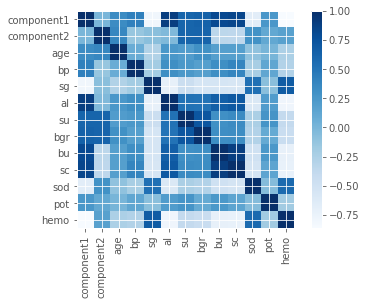

In [106]:
plt.imshow(df_corr.corr(), cmap = plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_corr.columns))]
plt.xticks(tick_marks, df_corr.columns, rotation='vertical')
plt.yticks(tick_marks, df_corr.columns)

Interpretation of the principal components is based on finding which variables are most strongly correlated with each component, i.e., which of these numbers are large in magnitude, the farthest from zero in either direction. Which numbers we consider to be large or small is of course is a subjective decision. You need to determine at what level the correlation is of importance

From the visualization it is possible notice that component 1 is more correlated with 'sc', 'bu', 'hemo' and 'al' feature, while component 2 is more correlated with 'bgr'.

#### Weaknesses of PCA <br>
1)  PCA is sensitive to the scaling of our features. PCA maximizes variability based off of variance, and then projects our original data on these directions of maximal variances.<br><br>
2) PCA is fast, but for very large datasets it might take a while to train.  If you're willing to sacrifice a bit of accuracy for computational efficiency, SciKit-Learn allows us to solve PCA using a offers an approximate matrix solver called *RandomizedPCA*. <br> <br>
3) PCA will only, therefore, be able to capture the underlying linear shapes and variance within our data and cannot discern any complex, nonlinear intricacies. For such cases, we will have to make use different dimensionality reduction algorithms, such as [*Isomap*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).

**Some useful links:**
- [Interpreting PCA](https://newonlinecourses.science.psu.edu/stat505/node/54/); <br>
- [Another method for interpreting PCA](http://www.stat.cmu.edu/~cshalizi/350/lectures/10/lecture-10.pdf); <br>
- [Interactive PCA Demo](http://setosa.io/ev/principal-component-analysis/); <br>
- [A tutorial on Principal Components Analysis](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf); <br>
<br>
With this paragraph ends the notebook "Transforming", the next notebook will be "Modeling".
<br><br>
[Click here to return to the top of the page](#start)<a href='#start'></a>
<br>
<br>
If you have any doubts, you can write to us on Teams!<br>
See you soon!